# Practice: Attention Basics
Original notebook is provided by Udacity at [github](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/Attention_Basics.ipynb).

In this notebook, we look at how attention is implemented. We will focus on implementing attention in isolation from a larger model. That's because when implementing attention in a real-world model, a lot of the focus goes into piping the data and juggling the various vectors rather than the concepts of attention themselves.

We will implement attention scoring as well as calculating an attention context vector.

## Attention Scoring

### Inputs to the scoring function
Let's start by looking at the inputs we'll give to the scoring function. We will assume we're in the first step in the decoding phase. The first input to the scoring function is the hidden state of decoder (assuming a toy RNN with three hidden nodes — not usable in real life, but easier to illustrate):

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

In [2]:
dec_hidden_state = np.transpose(np.matrix([5, 1, 20]))

Let's visualize this vector:

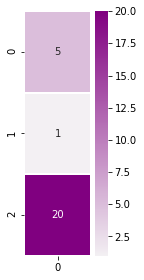

In [3]:
# Let's visualize our decoder hidden state:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(
    dec_hidden_state,
    annot=True,
    cmap=sns.light_palette("purple", as_cmap=True),
    linewidths=1
);

Our first scoring function will score a single annotation (encoder hidden state), which looks like this:

In [4]:
annotation = np.transpose(np.matrix([3, 12, 45]))  # e.g. encoder hidden state

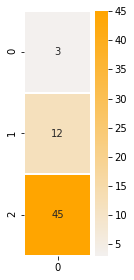

In [5]:
# Let's visualize the single annotation:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(
    annotation,
    annot=True,
    cmap=sns.light_palette("orange", as_cmap=True),
    linewidths=1
);

### IMPLEMENT: Scoring a Single Annotation

Let's calculate the dot product of a single annotation. NumPy's [dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) is a good candidate for this operation.

In [6]:
def single_dot_attention_score(dec_hidden_state, enc_hidden_state):
    # Return the dot product of the two vectors:
    return np.dot(dec_hidden_state.T, enc_hidden_state)

single_dot_attention_score(dec_hidden_state, annotation)

matrix([[927]])

### Annotations Matrix

Let's now look at scoring all the annotations at once. To do that, here's our annotation matrix:

In [7]:
annotations = np.transpose([[3, 12, 45],
                            [59, 2, 5],
                            [1, 43, 5],
                            [4, 3, 45.3]])

And it can be visualized like this (each column is a hidden state of an encoder time step):

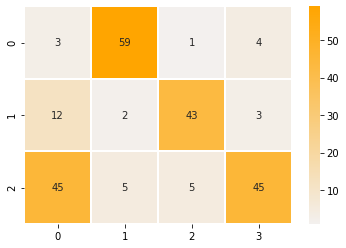

In [8]:
# Let's visualize our annotations (each column is an annotation):
ax = sns.heatmap(
    annotations,
    annot=True,
    cmap=sns.light_palette("orange", as_cmap=True),
    linewidths=1
);

### IMPLEMENT: Scoring All Annotations at Once

Let's calculate the scores of all the annotations in one step using matrix multiplication. Let's continue to use the dot scoring method.

<img src="https://github.com/neychev/made_nlp_course/blob/master/week05_machine_translation/img/scoring_functions.png?raw=1" />

To do that, we'll have to transpose `dec_hidden_state` and [matrix multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html) it with `annotations`.

In [9]:
def dot_attention_score(dec_hidden_state, annotations):
    # Return the product of dec_hidden_state transposed and enc_hidden_states:
    return np.dot(dec_hidden_state.T, annotations)

attention_weights_raw = dot_attention_score(dec_hidden_state, annotations)
attention_weights_raw

matrix([[927., 397., 148., 929.]])

Looking at these scores, can you guess which of the four vectors will get the most attention from the decoder at this time step?

### Softmax

Now that we have our scores, let's apply softmax:

<img src="https://github.com/neychev/made_nlp_course/blob/master/week05_machine_translation/img/softmax.png?raw=1" />

In [10]:
def softmax(x):
    x = np.array(x, dtype=np.float128)
    x -= x.min()  # for numerical stability
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1)

attention_weights = softmax(attention_weights_raw)
attention_weights

array([[1.19202922e-001, 7.94715151e-232, 5.76614420e-340,
        8.80797078e-001]], dtype=float128)

Even when knowing which annotation will get the most focus, it's interesting to see how drastic softmax makes the end score become. The first and last annotation had the respective scores of 927 and 929. But after softmax, the attention they'll get is 0.12 and 0.88 respectively.

### Applying the scores back on the annotations

Now that we have our scores, let's multiply each annotation by its score to proceed closer to the attention context vector. This is the multiplication part of this formula (we'll tackle the summation part in the latter cells).

<img src="https://github.com/neychev/made_nlp_course/blob/master/week05_machine_translation/img/Context_vector.png?raw=1" />

In [11]:
def apply_attention_scores(attention_weights, annotations):
    # Multiple the annotations by their weights:
    return np.multiply(annotations, attention_weights)

In [12]:
applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[3.57608766e-001, 4.68881939e-230, 5.76614420e-340,
        3.52318831e+000],
       [1.43043506e+000, 1.58943030e-231, 2.47944200e-338,
        2.64239123e+000],
       [5.36413149e+000, 3.97357575e-231, 2.88307210e-339,
        3.99001076e+001]], dtype=float128)

Let's visualize how the context vector looks now that we've applied the attention scores back on it:

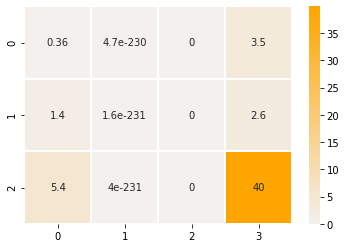

In [13]:
# Let's visualize our annotations after applying attention to them:
ax = sns.heatmap(
    applied_attention,
    annot=True,
    cmap=sns.light_palette("orange", as_cmap=True),
    linewidths=1
);

Contrast this with the raw annotations visualized earlier in the notebook, and we can see that the second and third annotations (columns) have been nearly wiped out. The first annotation maintains some of its value, and the fourth annotation is the most pronounced.

### Calculating the Attention Context Vector

All that remains to produce our attention context vector now is to sum up the four columns to produce a single attention context vector.

In [14]:
def calculate_attention_vector(applied_attention):
    return np.sum(applied_attention, axis=1)

attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 3.88079708,  4.0728263 , 45.26423912], dtype=float128)

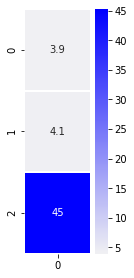

In [15]:
# Let's visualize the attention context vector:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(
    np.transpose(np.matrix(attention_vector)),
    annot=True,
    cmap=sns.light_palette("Blue", as_cmap=True),
    linewidths=1
);

Now that we have the context vector, we can concatenate it with the hidden state and pass it through a hidden layer to produce the result of this decoding time step.

## Your turn

Now implement the _general_ and _concat_ attention scores and check it below.

#### General attention scoring

In [16]:
# Yeah, you need to initialize the matrix first
# (just use random, the main idea is the dimentionality):
Wa = np.random.randn(dec_hidden_state.shape[0], annotations.shape[0])

def general_attention_score(dec_hidden_state, annotations, Wa):
    # Return the product of dec_hidden_state transpose,
    # Wa, and enc_hidden_states:
    return np.dot(np.dot(dec_hidden_state.T, Wa), annotations)

attention_weights_raw = general_attention_score(dec_hidden_state,
                                                annotations, Wa)
attention_weights_raw

matrix([[178.39573938, 871.14217469, 955.32567706,  -8.23505583]])

In [17]:
# Some post-processing like above:
attention_weights = softmax(attention_weights_raw)
attention_weights

array([[3.83367453e-338, 2.75149960e-037, 1.00000000e+000,
        3.39539829e-419]], dtype=float128)

In [18]:
applied_attention = apply_attention_scores(attention_weights, annotations)
applied_attention

array([[1.15010236e-337, 1.62338476e-035, 1.00000000e+000,
        1.35815932e-418],
       [4.60040944e-337, 5.50299920e-037, 4.30000000e+001,
        1.01861949e-418],
       [1.72515354e-336, 1.37574980e-036, 5.00000000e+000,
        1.53811543e-417]], dtype=float128)

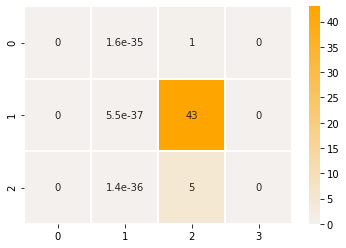

In [19]:
ax = sns.heatmap(
    applied_attention,
    annot=True,
    cmap=sns.light_palette("orange", as_cmap=True),
    linewidths=1
);

In [20]:
attention_vector = calculate_attention_vector(applied_attention)
attention_vector

array([ 1., 43.,  5.], dtype=float128)

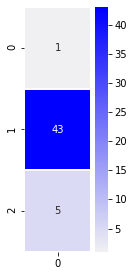

In [21]:
plt.figure(figsize=(1.5, 4.5))
sns.heatmap(
    np.transpose(np.matrix(attention_vector)),
    annot=True,
    cmap=sns.light_palette("Blue", as_cmap=True),
    linewidths=1
);

### Concat attention scoring

In [22]:
# And here you need to initialize both the vector va and the matrix Wa
# (again, random is fine):
Wa = np.random.randn(dec_hidden_state.shape[0], annotations.shape[0])
va = np.random.randn(dec_hidden_state.shape[0])

def concat_attention_score(dec_hidden_state, annotations, Wa, va):
    # Return the product of va transposed, tanh of product of Wa and
    # concatenation of dec_hidden_state and enc_hidden_states:
    result = np.hstack((dec_hidden_state, annotations))
    result = np.dot(Wa, result)
    result = np.tanh(result)
    result = np.dot(va, result)
    return result

attention_weights_raw = concat_attention_score(dec_hidden_state, annotations,
                                               Wa, va)
attention_weights_raw

matrix([[ 0.20917794,  0.20916041,  0.20916041, -0.95370235,  0.20916382]])

In [23]:
# And again some post-processing:
attention_weights = softmax(attention_weights_raw)
attention_weights

array([[0.23188216, 0.23187809, 0.23187809, 0.07248278, 0.23187888]],
      dtype=float128)

In [24]:
applied_attention = apply_attention_scores(
    attention_weights, np.hstack((dec_hidden_state, annotations))
)
applied_attention

matrix([[ 1.15941078,  0.69563427, 13.6808074 ,  0.07248278,  0.92751553],
        [ 0.23188216,  2.7825371 ,  0.46375618,  3.1167595 ,  0.69563665],
        [ 4.63764312, 10.43451412,  1.15939046,  0.3624139 , 10.50411336]],
       dtype=float128)

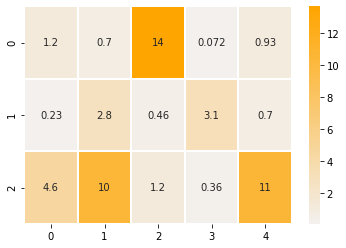

In [25]:
ax = sns.heatmap(
    applied_attention,
    annot=True,
    cmap=sns.light_palette("orange", as_cmap=True),
    linewidths=1
);

# Part 2: Google Colab intro

We roll back to the week03 practice: name generation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
from IPython.display import clear_output
from random import sample

In [ ]:
start_token = " "

def read_names(path_to_file):
    global start_token
    
    with open(path_to_file) as f:
        names = f.read()[:-1].split('\n')
        names = [start_token + line for line in names]
        return names

In [ ]:
try:
    names = read_names('../datasets/names_dataset/names')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names -nc -O names
    names = read_names('./names')

In [ ]:
try:
    names_ru = read_names('../datasets/names_dataset/names_ru')
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/names_dataset/names_ru -nc -O names_ru
    names_ru = read_names('./names_ru')

In [ ]:
print ('n samples = ',len(names_ru))
for idx in np.arange(0, len(names), 1000):
    print(names[idx], names_ru[idx])

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25, label='en');

plt.title('Sequence length distribution')
plt.hist(list(map(len, names_ru)),bins=25, alpha=0.5, label='ru');
plt.legend()

In [ ]:
all_tokens_set_en = set()
for name in names:
    all_tokens_set_en.update(set(name))

# List of all unique characters in the dataset:
tokens_en = list(all_tokens_set_en)

num_tokens_en = len(tokens_en)
print ('num_tokens = ', num_tokens_en)

assert 50 < num_tokens_en < 60, (
    "Names should contain within 50 and 60 unique tokens depending on encoding."
)

In [ ]:
all_tokens_set_ru = set()
for name in names_ru:
    all_tokens_set_ru.update(set(name))

# List of all unique characters in the dataset:
tokens_ru = list(all_tokens_set_ru)

num_tokens_ru = len(tokens_ru)
print ('num_tokens = ', num_tokens_ru)

assert 50 < num_tokens_ru < 60, (
    "Names should contain within 50 and 60 unique tokens depending on encoding."
)

In [ ]:
token_to_id_en = {
    token: idx for idx, token in enumerate(tokens_en)
}

token_to_id_ru = {
    token: idx for idx, token in enumerate(tokens_ru)
}

In [ ]:
assert len(tokens_ru) == len(token_to_id_ru), (
    "Dictionaries must have the same size."
)

for i in range(num_tokens_ru):
    assert token_to_id_ru[tokens_ru[i]] == i, (
        "Token identifier must be it's position in tokens list."
    )

for i in range(num_tokens_en):
    assert token_to_id_en[tokens_en[i]] == i, (
        "Token identifier must be it's position in tokens list."
    )

print("Seems alright!")

In [ ]:
def to_matrix(names, token_to_id, max_len=None, pad=None, dtype='int32',
              batch_first=False):
    """Casts a list of names into rnn-digestable matrix"""
    pad = token_to_id[' ']
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_tokens=num_tokens_en, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

In [ ]:
model = MyModel()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []

# The model applies over the whole sequence:
batch_ix = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [ ]:
logp_seq = model(batch_ix)

loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens_en),
                 batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter()

In [ ]:
writer.add_graph(model, batch_ix)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token_to_id_en, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens_en),
                     batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()

    opt.step()
    opt.zero_grad()

    # compute loss

    # YOUR CODE HERE

    # train with backprop

    # YOUR CODE HERE

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        writer.add_scalar('train loss', history[-1], i)

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

# More serious: char-level machine translation

Let's try to transliterate these names from English to Russian. So we need 2 models: encoder and decoder.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_tokens=num_tokens_en, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_last = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_last

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_tokens=num_tokens_ru, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, enc_last_state):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, h_last = self.rnn(self.emb(x), enc_last_state)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, h_last

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        # YOUR CODE HERE

    def forward(self, src, trg):
        # YOUR CODE HERE

        return logp_seq

In [ ]:
nmt_model = Seq2Seq()
opt = torch.optim.Adam(nmt_model.parameters())
criterion = nn.NLLLoss()

In [ ]:
# example
indices = np.random.choice(np.arange(len(names)), size=32)
batch_en = to_matrix(np.array(names)[indices], token_to_id=token_to_id_en,
                     max_len=MAX_LENGTH)
input_tensor = torch.from_numpy(batch_en).type(torch.int64)

batch_ru = to_matrix(np.array(names_ru)[indices], token_to_id=token_to_id_ru,
                     max_len=MAX_LENGTH)
target_tensor = torch.from_numpy(batch_ru).type(torch.int64)

In [ ]:
out = nmt_model(input_tensor, target_tensor)

In [ ]:
idx_to_token_en = {idx: token for token, idx in token_to_id_en.items()}
idx_to_token_ru = {idx: token for token, idx in token_to_id_ru.items()}

In [ ]:
a = out.argmax(dim=-1)

In [ ]:
# Train your model here

Let's take a look at the results

In [ ]:
def get_example(idx):
    translated = ''.join([idx_to_token_ru[x] for x in a[:, idx].numpy()])
    original = ''.join(
        [idx_to_token_en[x] for x in input_tensor[:, idx].numpy()]
    )
    print(original, translated)

In [ ]:
get_example(9)